# Super basic: defining models, sampling from models, with Torch tensors/variables.

In [5]:
%load_ext autoreload
%autoreload 2

# import some dependencies
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np

import pyro
import pyro.distributions as dist

loc = Variable(Tensor([0.]), requires_grad=True)
scale = Variable(Tensor([1.]), requires_grad=True)
normal = dist.Normal(loc, scale) # create a normal distribution object
x = normal.sample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
('sample', tensor([-0.6905]))
('log prob', tensor([-1.1573]))


# Composing functions

In [6]:
def weather():
    r = Variable(Tensor([0.3]), requires_grad=True)
    cloudy = pyro.sample('cloudy', dist.Bernoulli(r))
    cloudy = 'cloudy' if cloudy.data[0] == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    
    loc = Variable(Tensor([mean_temp]), requires_grad=True)
    scale = Variable(Tensor([scale_temp]), requires_grad=True)

    temp = pyro.sample('temp', dist.Normal(loc, scale))
    return cloudy, temp.data[0]

for _ in range(3):
    print(weather())
    
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    loc = Variable(Tensor([expected_sales]), requires_grad=True)
    scale = Variable(Tensor([10.]), requires_grad=True)
    ice_cream = pyro.sample('ice_cream', dist.Normal(loc, scale))
    return ice_cream

for _ in range(3):
    print(ice_cream_sales())


('sunny', tensor(60.9440))
('sunny', tensor(76.8089))
('cloudy', tensor(47.2491))
tensor([ 40.1398])
tensor([ 44.5584])
tensor([ 186.7144])


# Inference for the scale example

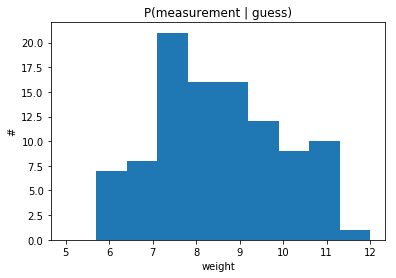

In [17]:
import pyro.infer
import pyro.optim
import matplotlib.pyplot as plt

def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    loc = Variable(Tensor([guess]), requires_grad=True)
    scale = Variable(Tensor([1.0]), requires_grad=True)
    weight = pyro.sample("weight", dist.Normal(loc, scale))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    loc = Variable(Tensor([weight.data[0]]), requires_grad=True)
    scale = Variable(Tensor([0.75]), requires_grad=True)
    return pyro.sample("measurement", dist.Normal(loc, scale))

guess = 8.5
posterior = pyro.infer.Importance(scale, num_samples=100)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))

plt.figure()
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
lt.ylabel("#");

tensor([ 9.2406])


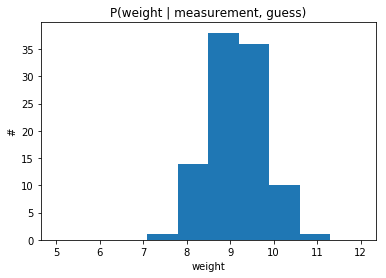

In [22]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=1000).run(guess), sites="weight")

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

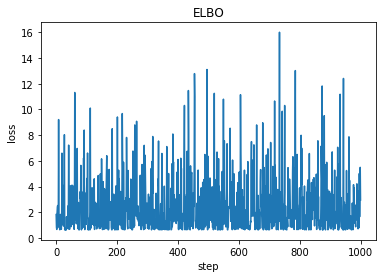

In [27]:
pyro.clear_param_store()
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

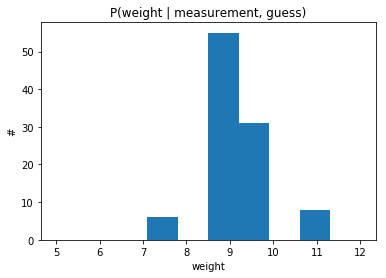

In [28]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

# SVI tutorial #1

In [4]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

torch.set_default_tensor_type('torch.cuda.FloatTensor')

n_steps = 2000

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in pyro.irange("data_loop", len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


....................
based on the data and our prior belief, the fairness of the coin is 0.539 +- 0.090
